# Import dependencies and libraries

In [2]:
import os
import json
import pickle as pickle

import numpy as np

# for fitting empirical distributions for radius of gyration and jump length
import powerlaw

# for visualization
import matplotlib
import matplotlib.pyplot as plt

# trackintel -> the functions will be imported with full names
import trackintel as ti


In [3]:
# options for better printing and visualizing

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

%matplotlib inline

In [7]:
# get the data dir from the config file -> default stored in Data/Geolife/Data folder

DATA_DIR = os.path.join("..", "..", "paths.json")
with open(DATA_DIR) as json_file:
    CONFIG = json.load(json_file)

save_dir = os.path.join("..", "..", CONFIG["data_dir"])

# Load Geolife data
Trackintel provides a function [read_geolife](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_geolife) to directly load [Geolife](https://www.microsoft.com/en-us/research/publication/geolife-gps-trajectory-dataset-user-guide/) dataset into the trackintel positionfixes. For the tutorial and interactive section, we provided you a sample dataset with 20 selected users from the geolife dataset. This can be directly loaded from the `save_dir`. 

In [8]:
pfs, mode_labels = ti.io.read_geolife(save_dir, print_progress=True)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


## Reading your own data
Trackintel provides an I/O module for accessing movement data and storing intermediate or final results in a file or database. Three methods for converting movement data with attached attribute information to Trackintel-compatible formats are provided:
1) reading from Pandas Dataframes and Geopandas Geodataframes (**recommended**)
2) reading and writing from CSV file formats
3) reading and storing from PostgreSQL databases with PostGIS extension. Check the [input/output](https://trackintel.readthedocs.io/en/latest/modules/io.html) module for more information. 

An important consideration before loading data is to find the appropriate movement level for your data. Depending on the semantics of the data, you should call different reading functions, e.g., [read_positionfixes_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_positionfixes_csv) or [read_staypoints_csv](https://trackintel.readthedocs.io/en/latest/modules/io.html#trackintel.io.read_staypoints_csv). 

In [5]:
# TODO: use ti.read_positionfixes_csv() or ti.read_staypoints_csv() for loading your data. Check the documentation for the required input parameters
# selected_pfs = ti.read_positionfixes_csv()

# Calculate Jump length

## Generate staypoints
Jump length measures the distance between consecutive stays. This definition corresponds to trackintel's **staypoint** data model. The following code is to generate staypoints from the raw positionfixes with the trackintel function [generate_staypoints](https://trackintel.readthedocs.io/en/latest/modules/preprocessing.html#trackintel.preprocessing.generate_staypoints). Click on the link to check the documentation on the meaning of the input parameters.

In [9]:
pfs, sp = pfs.generate_staypoints(gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=-1)

/Users/yehong/mambaforge/envs/reprotrack/lib/python3.9/site-packages/trackintel/preprocessing/positionfixes.py:113: UserWarning: 1690 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


## Calculate jump length
Trackintel provide implementations for calculating the jumplength with staypoints that have geometry column. Check out the function [trackintel.analysis.metrics.jump_length()](https://trackintel.readthedocs.io/en/latest/modules/analysis.html#trackintel.analysis.jump_length). The output of the function is available as a series that shares the same index as the input dataframe. This ensures that we can use a column to hold the result (e.g., using `sp["jumplength"]`).

In [10]:
sp["jumplength"] = ti.analysis.jump_length(sp)
jumplength_arr = sp.dropna(subset=["jumplength"])["jumplength"].values

## Visualize with powerlaw library 
The [powerlaw](https://github.com/jeffalstott/powerlaw) package provides functionalities to fit power-law, truncated power law, and log normal distributions to the original data. It also provides functionalities to plot all the fitted distributions on the same plot. We use the powerlaw package to visualize the radius of calculation result. 

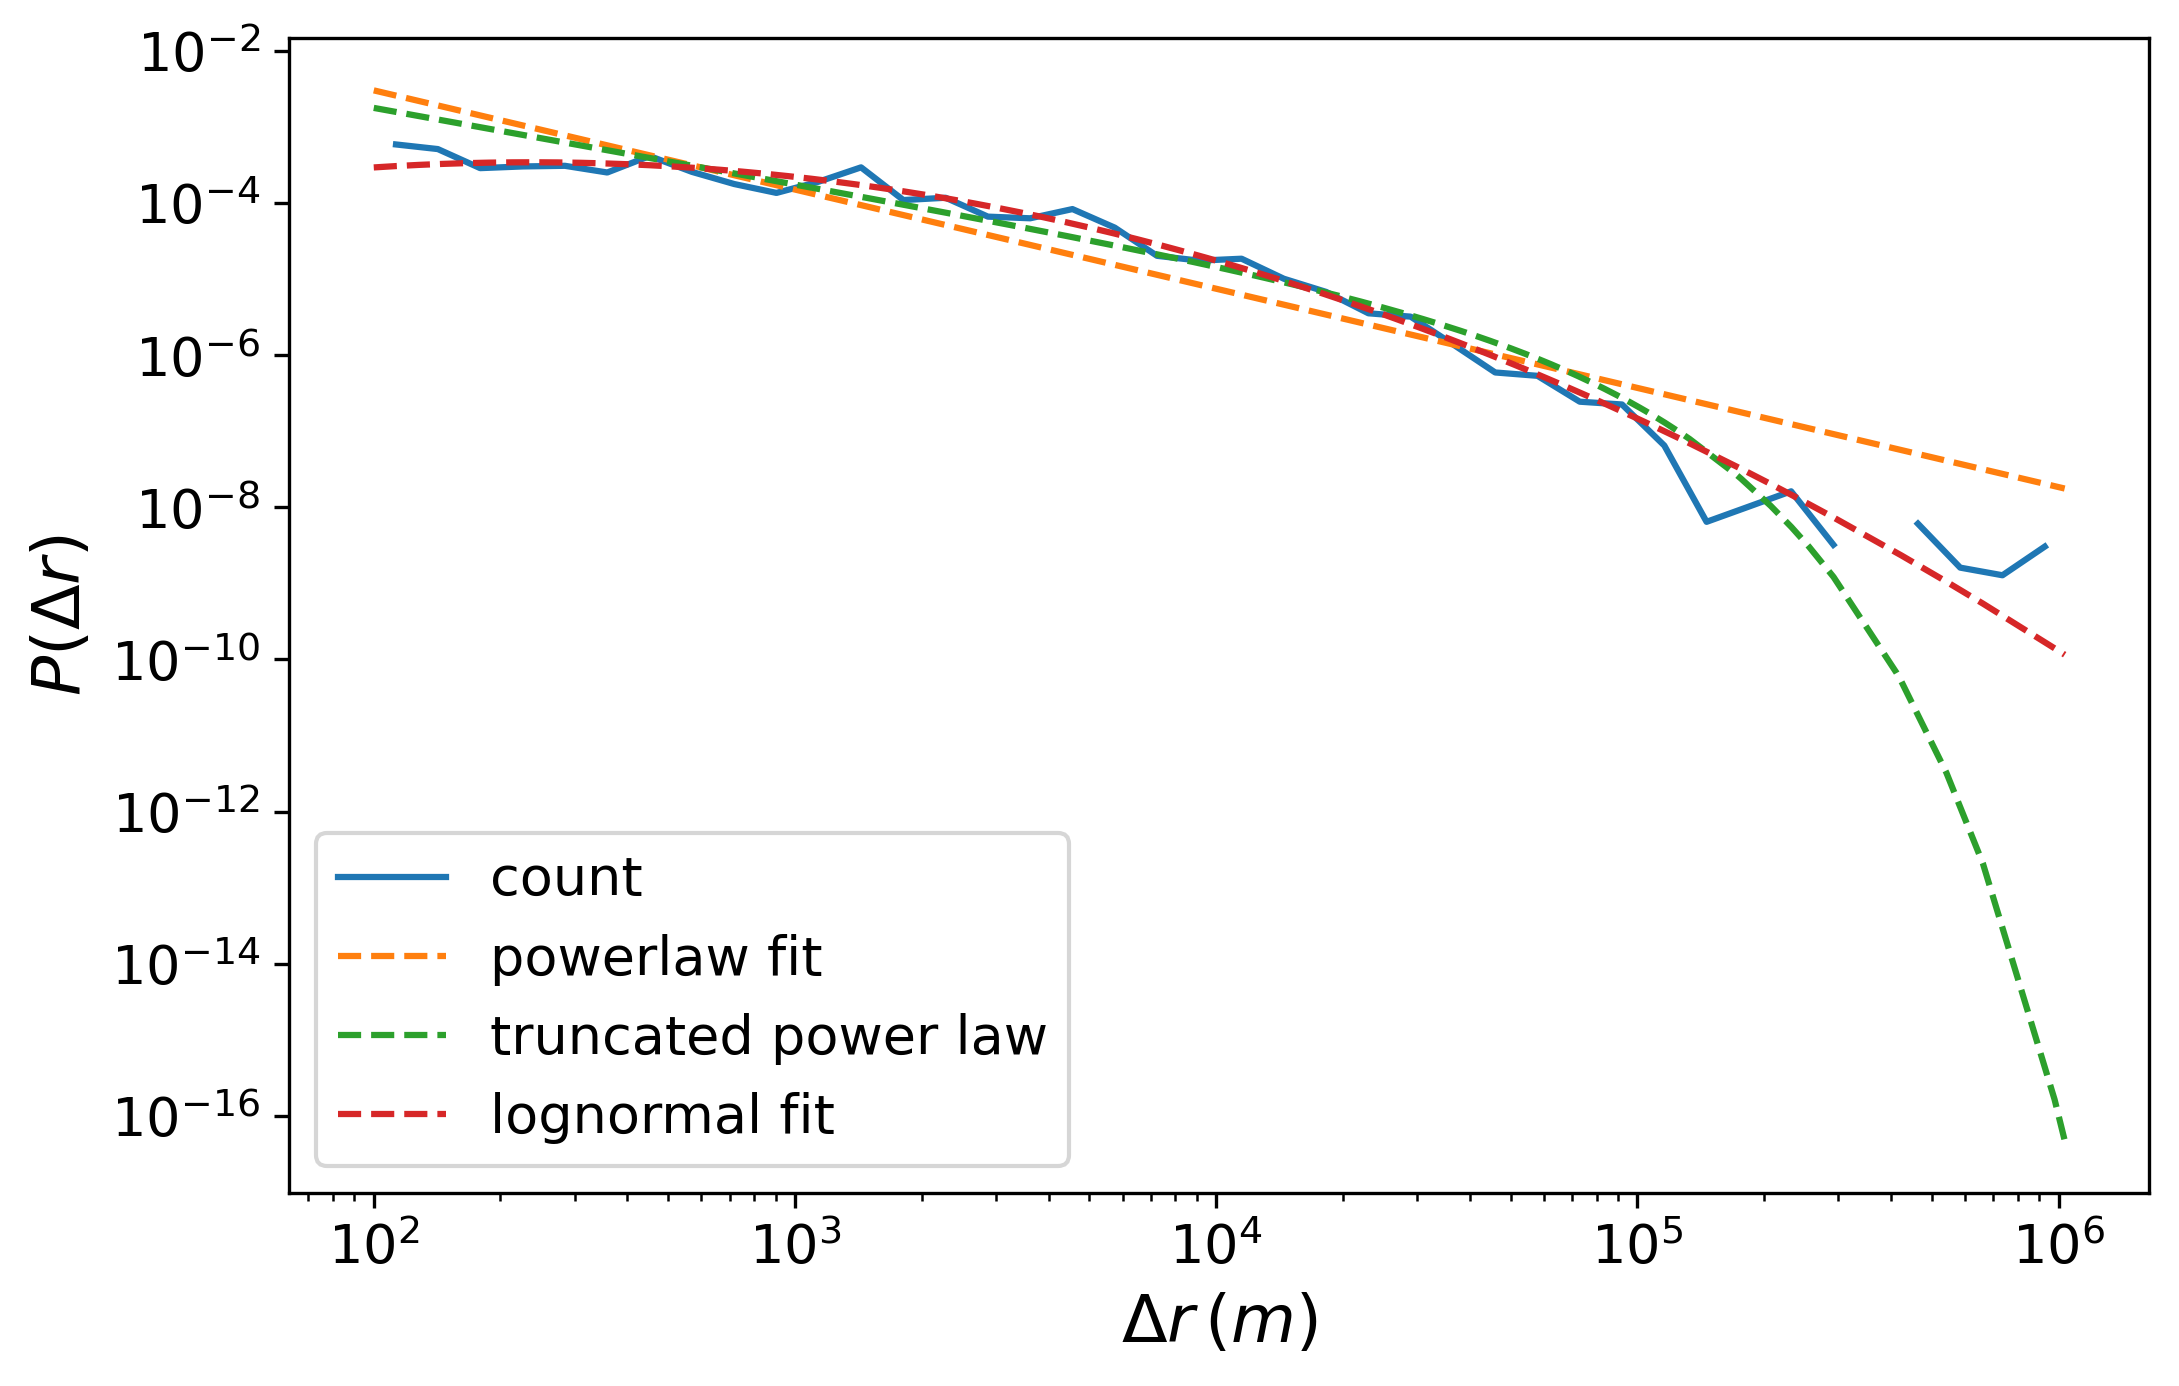

In [11]:
plt.figure(figsize=(8, 5))

jp = jumplength_arr[jumplength_arr>100]

# fit power law
fit = powerlaw.Fit(jp, xmin=100)

# plotting
powerlaw.plot_pdf(jp, label="count")
fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")


plt.legend(prop={"size": 13})
plt.xlabel("$\Delta r\,(m)$", fontsize=16)
plt.ylabel("$P(\Delta r)$", fontsize=16)

plt.show()